# Grade: /20 pts

# Assignment 06: Regularization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, make_scorer

pd.set_option('display.max_columns', 500)

%matplotlib inline

### Question1: Preprocessing (1pt)
**Make sure to only use the imports included in the first cell. Any additional imports used will result in 0.** <br>
Tasks:
* Load the data present in 'footballer_small.csv' using the pandas library and store the loaded data in a dataframe
* Drop the variables: 'ID','club','club_logo','flag', 'nationality','photo','potential', 'birth_date'
* Dummy code the variables: work_rate_att, work_rate_def, preferred_foot. **Because we are running a regularized model, we do not want to drop the first column**
* Get a test data set of size 500 - to make results comparable to solutions, set random_state = 0 <br>

In [2]:
data = pd.read_csv("footballer_small.csv")

#dropping columns
data = data.drop(["ID", "club", "club_logo", "flag", "nationality", "photo", "potential", "birth_date"], axis=1)

#converting columns into dummy variables
data = pd.get_dummies(data, columns=["work_rate_att", "work_rate_def", "preferred_foot"])

#data set of 500
x = data.drop("overall", axis="columns")
y = data.overall
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size = 500, random_state = 0)
#data = data.sample(n=500, random_state=0, axis=0)

print(Xtest.shape)
print(Xtrain.shape)
print(Xtest)

(500, 48)
(2500, 48)
      age  height_cm  weight_kg  pac  sho  pas  dri  def  phy  \
311    20      190.0       81.0   57   24   44   49   60   64   
1025   24      183.0       71.0   78   65   62   71   44   63   
1587   27      193.0       83.0   64   57   55   63   60   52   
2941   29      175.0       71.0   76   66   71   70   27   60   
2980   29      189.0       85.0   66   68   63   72   59   64   
...   ...        ...        ...  ...  ...  ...  ...  ...  ...   
49     26      179.0       79.0   74   62   57   68   27   63   
1804   23      175.0       74.0   71   48   63   66   63   72   
1374   34      180.0       70.0   37   37   58   50   70   65   
2985   31      193.0       83.0   39   28   41   34   61   70   
993    24      190.0       91.0   49   39   44   42   69   76   

      international_reputation  skill_moves  weak_foot  crossing  finishing  \
311                          1            2          3        38         22   
1025                         1          

## Question 2: Building the pipeline that preprocesses the data (2pts)
In order to properly build the regression model, the features need to be standardized so that no feature can dominate others in determining the prediction values due to differences in feature scales. Build the pipeline that preprocesses the feature columns of the training data and create a linear regression model. Plot the data before and after the standardization for the stamina feature. <br>
In this question, there is no need to overwrite the training set's values. Create a new variable to include the standardized data. The original training data is needed for future exercises. <br>
### Question
Make observations about the plot.  

Text(0.5, 1.0, 'Standardized vs Not Standardized')

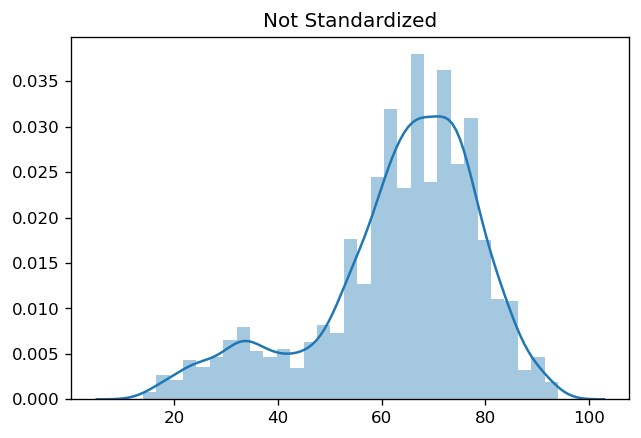

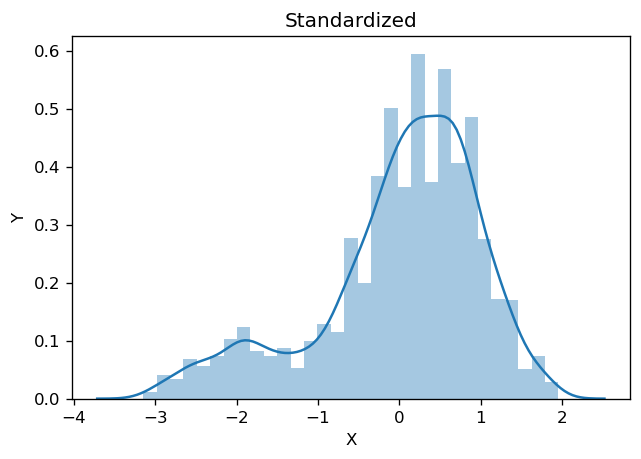

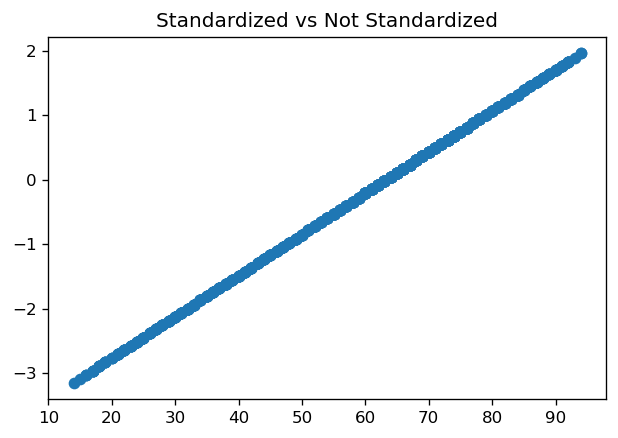

In [3]:
#need to standardize the features
pipe_model = Pipeline(steps = [('Scaler', StandardScaler()), ('linear regression', LinearRegression())]).fit(Xtrain, ytrain)
Xscale = pipe_model.named_steps['Scaler'].transform(Xtrain)

fig, ax = plt.subplots(dpi = 120)
sns.distplot(Xtrain.stamina.values)
plt.title('Not Standardized') #adding a title to the plot

fig, ax = plt.subplots(dpi = 120)
sns.distplot(Xscale[:,29])
plt.title('Standardized') #adding a title to the plot

plt.xlabel("X") #x axis label
plt.ylabel("Y") #y axis label

fig, ax = plt.subplots(dpi = 120)
ax.scatter(Xtrain.stamina.values, Xscale[:,29])
plt.title('Standardized vs Not Standardized') #adding a title to the plot


Therefore, this shows that the relationship between the standardized and non-standardized plots is a linear relationship

## Question 3: Creating a Complex feature model using 2-nd Polynomial features (2pts)
In this task, the training data consists of the quadratic terms and 2-way interactions of all features except one of standing_tackle, composure, and marking variable. <br> 
Create <b> four </b> different training sets:
* The first training set includes the quadratic terms and 2-way interactions of all the features. 
* The second/third/fourth training sets include all the features, their quadratic terms, and their 2-way interactions except the standing_tackle/composure/marking features. <br>

#### Hint: 
For the 2nd/3rd and 4th training sets, create the training sets without the aforementioned features and then apply polynomial expansion to the resultant sets. 
### Questions:
* How many linear terms are in each of the new feature set?
* How many squared terms are in each of the new feature set?
* How many interaction terms are in each of the new feature set? Give an example of one of the interaction terms. 

In [4]:
poly = sk.preprocessing.PolynomialFeatures(degree = 2, include_bias=0)

#training set 1
Xtrain1 = poly.fit_transform(Xtrain)
print (Xtrain1.shape)

#training set 2
Xtrain2 = Xtrain.drop(columns = ['standing_tackle'])
Xtrain2 = poly.fit_transform(Xtrain2)
print (Xtrain2.shape)

#training set 3
Xtrain3 = Xtrain.drop(columns = ['composure'])
Xtrain3 = poly.fit_transform(Xtrain3)
print (Xtrain3.shape)

#training set 4
Xtrain4 = Xtrain.drop(columns = ['marking'])
Xtrain4 = poly.fit_transform(Xtrain4)
print (Xtrain4.shape)


(2500, 1224)
(2500, 1175)
(2500, 1175)
(2500, 1175)


The first training set should have 48 linear terms, while the others would have 47. Then the first training set should have 48 squared terms, while the other would have 47. Then finally the first training set should have 1224 interaction terms, while the others should have 1175. An example of one of the interaction terms would be strength*work_rate_def

## Question 4: Evaluating the backward feature search (3 pts)
In this question, you have to use the pipeline created in question 2 and apply it to each of the training sets created in question 3. Use 10-fold cross validation to report the validation error on the training set using mean squared error as the metric. <br>
Show all the steps of the process and compare and analyze the results using the validation error reported. 

In [5]:
# Define mean squared error function
def MSE (y_true, y_pred):
    return np.mean((y_true-y_pred)**2) 
   
kf = KFold(n_splits=10,shuffle=False)
sc = make_scorer(MSE)

cv_scores1 = cross_val_score(pipe_model, Xtrain1, ytrain, cv=kf, scoring='neg_mean_squared_error')
cv_scores2 = cross_val_score(pipe_model, Xtrain2, ytrain, cv=kf, scoring='neg_mean_squared_error')
cv_scores3 = cross_val_score(pipe_model, Xtrain3, ytrain, cv=kf, scoring='neg_mean_squared_error')
cv_scores4 = cross_val_score(pipe_model, Xtrain4, ytrain, cv=kf, scoring='neg_mean_squared_error')

#print(f"CV score: {cv_scores}")
print(f"Training Set #1 CV loss: {-cv_scores1.mean()}")
print(f"Training Set #2 CV loss: {-cv_scores2.mean()}")
print(f"Training Set #3 CV loss: {-cv_scores3.mean()}")
print(f"Training Set #4 CV loss: {-cv_scores4.mean()}")

Training Set #1 CV loss: 2.97497799907761
Training Set #2 CV loss: 2.7538281155554123
Training Set #3 CV loss: 2.8059891727412714
Training Set #4 CV loss: 2.6968790066860477


All the steps of the process are showed above. Based on the validation error reported above, it tells us that the complete training set (Training Set #1) produces the highest CV loss. This means that the removed columns are not useful to generalize the data. 

## Question 5: Applying Ridge Regression (2 pts)
Build a pipeline that performs scaling and fits the ridge regression on the data that includes the polynomial expansion of all the features. The penalization parameter is set to 0.5. Use the pipeline to report the validation error using mean square error metric. Use 10-fold cross validation. 

In [6]:
pipe_model_RR = Pipeline(steps = [('poly', poly),('Standardize', StandardScaler()), ('Ridge', Ridge(alpha=0.5))])
RR_model = pipe_model_RR.fit(Xtrain, ytrain)

cv_scores1_RR = cross_val_score(pipe_model_RR, Xtrain, ytrain, cv=kf, scoring=sc)

print(f"Ridge Regression CV loss: {cv_scores1_RR.mean()}")

Ridge Regression CV loss: 1.714677002040895


## Question 6: Tune the Ridge coefficient for the 2nd-order model   (3pt)
Now use 10-fold CV on the training set to determine a good setting for the regularization coefficient. Perform the search going from $\lambda = \exp(-8), \cdots, \exp(6)$ in 15 evenly spaced increments on the log scale. Plot the mean squared error as a function of $\log(\lambda)$. 

### Questions: 

What is the best regularization parameter (actual not approximate)? 

Why does the error increase as $\lambda \rightarrow 0?$  Why does the error increase when $\lambda \rightarrow \infty$?  Answer in terms of the bias variance trade off.

In [ ]:
# Systematically vary the ridge coeficient on a log-scale
lam = np.exp(np.linspace(-8,6,15))
mse = np.zeros(15)

for i in range(lam.size):
    cv_scores = cross_val_score(Pipeline([('Scaler', StandardScaler()),('Ridge', Ridge(alpha=lam[i]))]), Xtrain1, ytrain, cv=kf,scoring = 'neg_mean_squared_error')
    mse[i]=-cv_scores.mean()
    
# Determine lowest value 
plt.scatter(np.log(lam),mse)

#determine the best regualarization parameter
parameters = {'alpha': lam}
rrmodel = GridSearchCV(Ridge(),parameters,cv =10, scoring ='neg_mean_squared_error')
rrmodel.fit(Xtrain, ytrain)

#Pipeline([('Scaler', StandardScaler()),('Ridge', Ridge())])

print(parameters)
print(rrmodel.best_params_)
#print(rrmodel.best_score_)

Therefore, this shows us that the best regularization parameter is 7.389 which is e^2, because it has the smallest cross-validation error. 

The error increases as 𝜆→0 and the error increases when 𝜆→∞ because as 𝜆 increases the variance decreases and the bias increases. The Ridge regression advantage is the bias variance trade off. As 𝜆 increases the flexibility of the ridge regression fit descreases, leading to decreased variance but increased bias. In general, if the relationship between ther resonse and the features is close to linear the least square estimates will have low bias but may have high variance. 

### Question 7: Test error  (2pt)
Now test how the ridge model, fitted to the whole training set, performs on the test data set. 


Report the following:

* The mean squared error on the test data - along with the 95% confidence interval, determined with the central limit theorem. 
* The proportion of the variance explained by your model - along wth a 95% confidence interval.

In [ ]:
pipe_model_RR = Pipeline(steps = [('poly', poly),('Standardize', StandardScaler()), ('Ridge', Ridge(alpha=7.389))])
RR_model = pipe_model_RR.fit(Xtrain, ytrain)
yp=RR_model.predict(Xtest)

#Mean squared error
mse = MSE(ytest, yp) 
se = (ytest-yp)**2
stderr = np.std(se) #standard deviation squared error

criticalv = 1.96
norm_ci = [mse - criticalv*(stderr/np.sqrt(ytest.size)), mse + criticalv*(stderr/np.sqrt(ytest.size))]

#Variance
variance = (yp - ytest.mean())**2
proportion = variance.mean()

stderr2 = np.std(variance)
norm_ci2 = [proportion - criticalv*(stderr2/np.sqrt(ytest.size)), proportion + criticalv*(stderr2/(ytest.size))]

print('MSE:', mse)
print('MSE bounds', norm_ci[0], ' and ', norm_ci[1])
print('Variance Mean:', proportion)
print('Variance bounds', norm_ci2[0], ' and ', norm_ci2[1])

#fig, ax = plt.subplots(dpi=120)
#sns.distplot(se)
#fig, ax = plt.subplots(dpi=120)
#sns.distplot(variance)

## Question 8: Analyzing Ridge Coefficients (3 pts)
In this question, you are first required to extract all the coefficients of the standing tackle, composure and marking features from the best model of question 7. After that, calculate the mean of the coefficients of the aforementioned features and analyze the results. Based on these observations, draw conclusions about the results in question 4. 

In [ ]:
#extract coefficents of standing tackle
coeff = RR_model.named_steps['Ridge'].coef_
features = (RR_model.named_steps['poly'].get_feature_names(Xtest.columns))
#print(coeff)

coefnames = {features[i]: coeff[i] for i in range(len(features))}
standing_tackle = coefnames.get('standing_tackle')
composure = coefnames.get('composure')
marking = coefnames.get('marking')
print(standing_tackle, composure, marking)

coeffmean = (standing_tackle + composure + marking)/3

print('Mean of the coefficients:', coeffmean)

Based on these observations, we can notice that the feature "marking" resulted in the largest coefficient here and then in Question 4 when the "marking" column was dropped (testing set #4) it resulted in the lowest test loss number. Therefore, we can conclude that the "marking" feature is the least significant, since excluding it results in a lower test loss. 

## Question 9: Lasso Regression (2pts)
Let us assume that you are building a linear regression model using only three features: standing tackle, marking, and composure to predict a player's overall rating. Based on the results of question 8, what do you think will be the features' coefficients while applying the lasso regression optimization? Answer in no more than 5 sentences. 

Lasso penalizes with the L1-norm and the L1 penalty has the effect of forcing some of the coefficients estimates to be exactly equal to zero when the tuning parameter is sufficently large. This means lasso regression performs variable selection. Based on the results in question 8, no feature shows a significant diffrence in their cross-validation score. This leads me to believe that no feature will be minimized to zero by the Lasso regression or they will all be minimized to zero since they are all so close in value. It can be estimated/assumed that "marking" would be the last feature to be minizmied to zero based on the fact it has the highest coefficent, however the coefficent does not tell us everything so we can not be sure. These results are all dependant on the scale of the alpha factor. 

## Note: 
After completing all the tasks and before submitting: 
* Restart you kernel by clicking 'Restart & Run all'
* Fix any errors resulting from the first step.
* Repeat the first two steps until no errors are encountered. 